In [1]:
! pip install -qq separability

In [2]:
import matplotlib.pyplot as plt
import torch
from separability import Model

In [3]:
# Configure initial model and tests
model_size, token_limit  = "facebook/opt-125m", 1000
opt = Model( model_size, limit=token_limit )

- Loaded facebook/opt-125m
 - Registered 12 OPT Attention Layers


tensor([[    2,    20,  4758,   439,    62,     5, 16745,     4]],
       device='cuda:0')
['</s>', ' The', ' cat', ' went', ' up', ' the', ' stairs', '.']


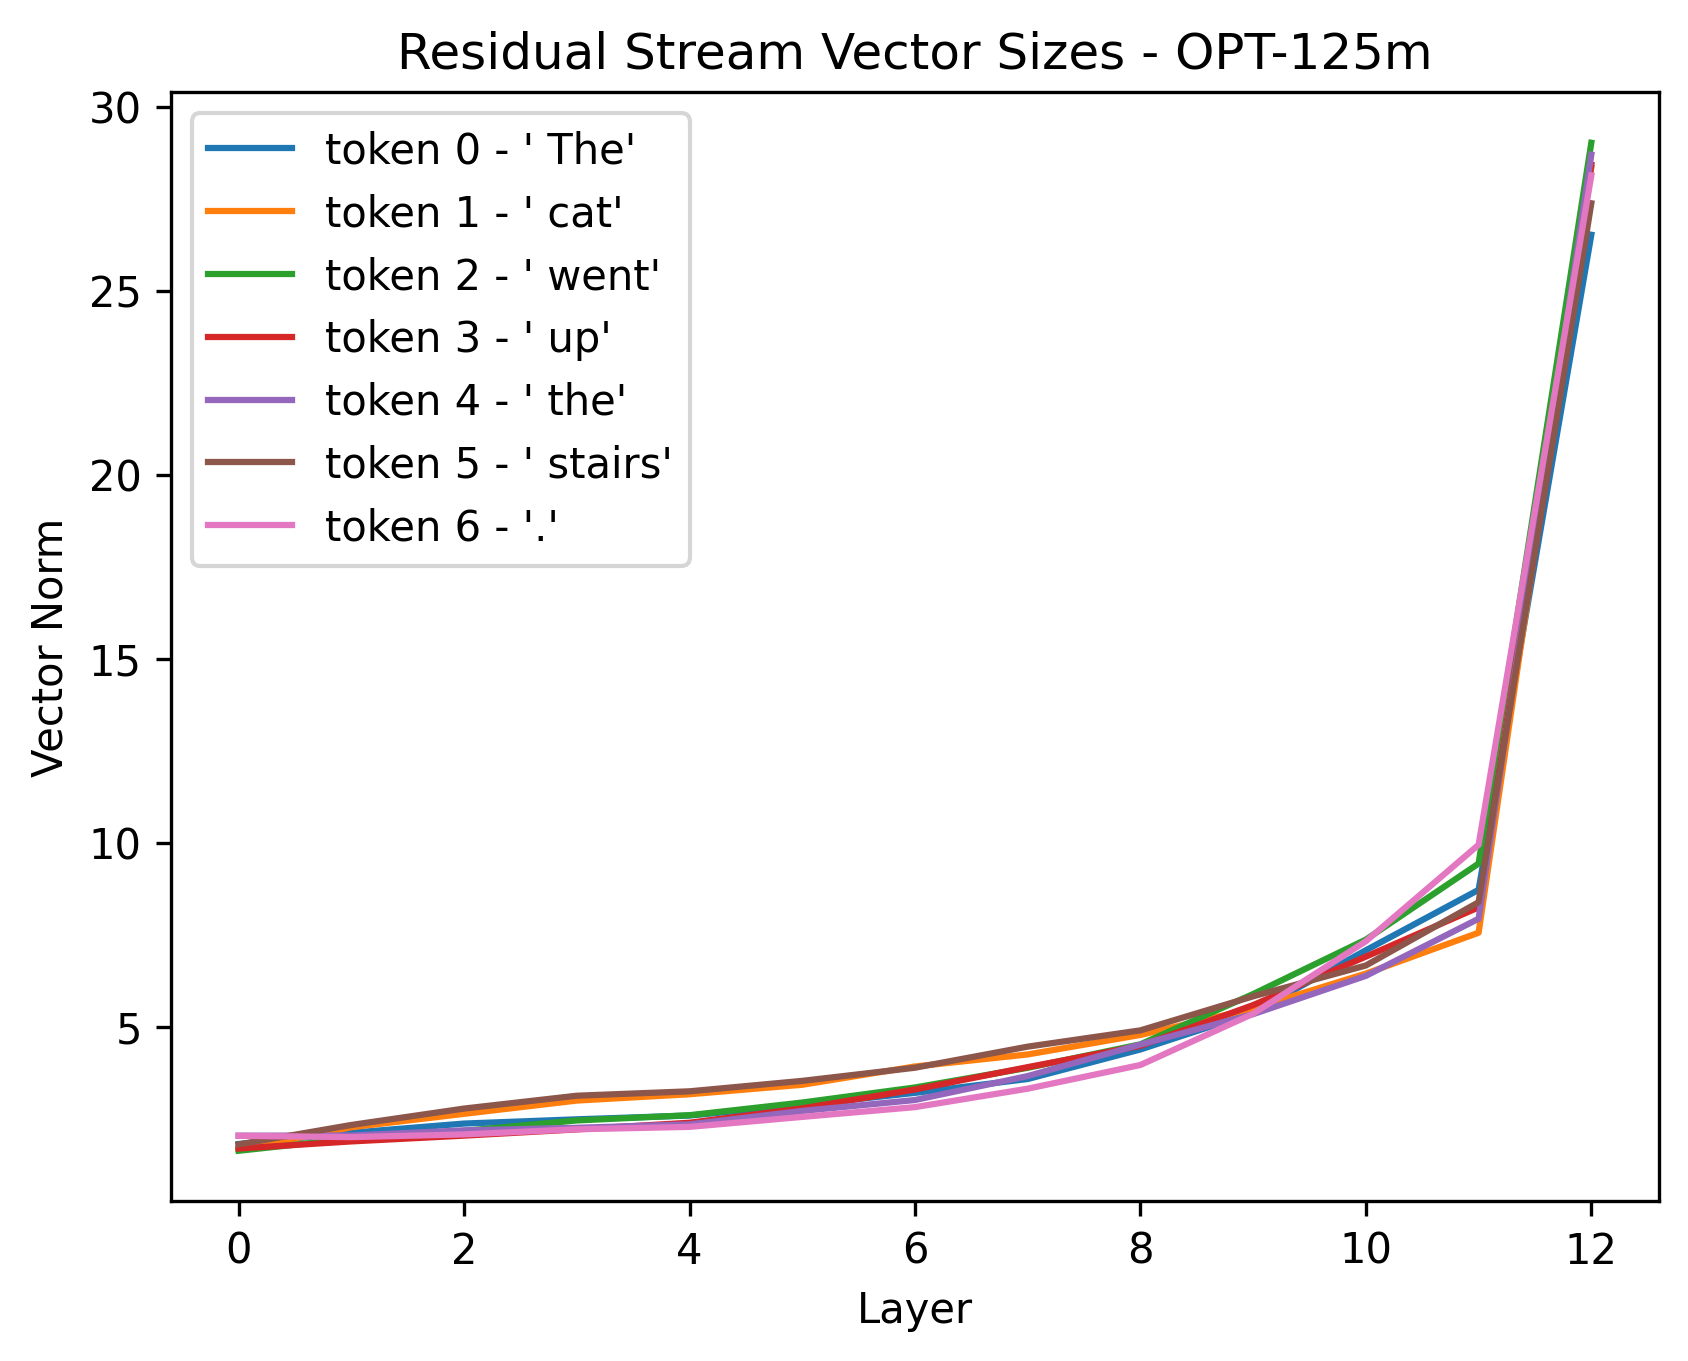

In [4]:
ids = opt.get_ids(" The cat went up the stairs.")
print(ids)
decoded_ids = [ opt.tokenizer.decode(_id) for _id in ids[0] ]
print(decoded_ids)

res = opt.get_residual_stream(input_ids=ids)
res_sizes = res.norm(dim=-1).T
for index, size in enumerate(res_sizes[1:]):
    # get only final outputs of decoder layers
    plt.plot(size[0::2].cpu(),
        label=f"token {index} - '{decoded_ids[index+1]}'"
    )
    
plt.title("Residual Stream Vector Sizes - OPT-125m")
plt.xlabel("Layer")
plt.ylabel("Vector Norm")
plt.legend()
plt.show()


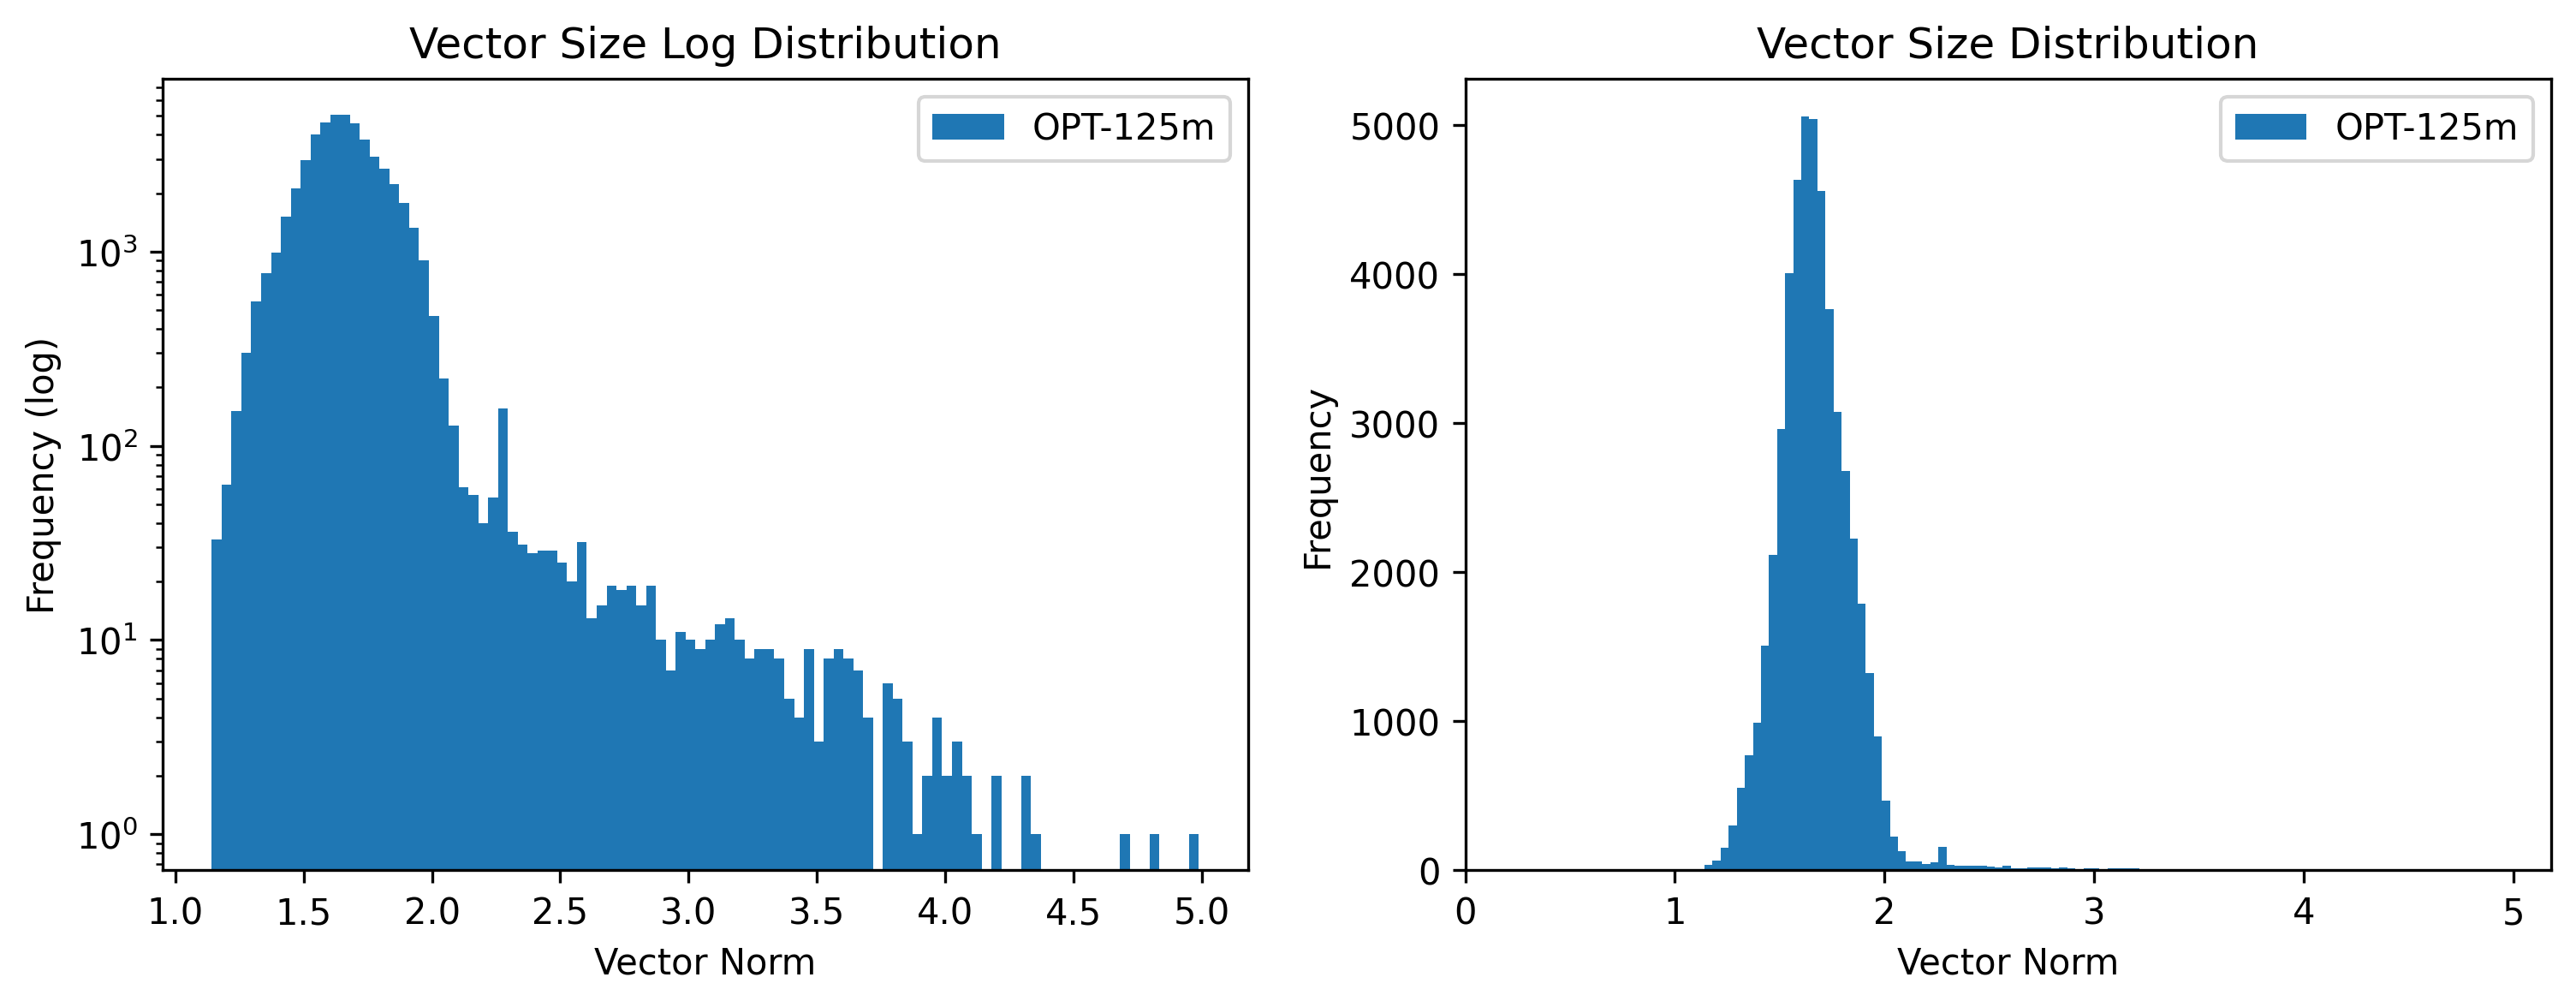

In [5]:
decoder = opt.model.decoder
W_E = decoder.embed_tokens.state_dict()["weight"]

norms = W_E.norm(dim=-1).cpu()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist( norms, bins=100, log=True, bottom=0, label="OPT-125m" )
ax1.set_xlabel("Vector Norm")
ax1.set_ylabel("Frequency (log)")
ax1.set_title("Vector Size Log Distribution")
ax1.legend()

ax2.hist( norms, bins=100, log=False, bottom=0, label="OPT-125m" )
ax2.set_title("Vector Size Distribution")
ax2.set_xlabel("Vector Norm")
ax2.set_ylabel("Frequency")

plt.xlim(0, None)
plt.legend()

plt.show()

tensor([0.4383, 0.4384, 0.7111,  ..., 0.4384, 0.4380, 0.4401], device='cuda:0')
 the
torch.Size([50272]) torch.Size([50272, 768]) torch.Size([768, 50272])
torch.Size([768])


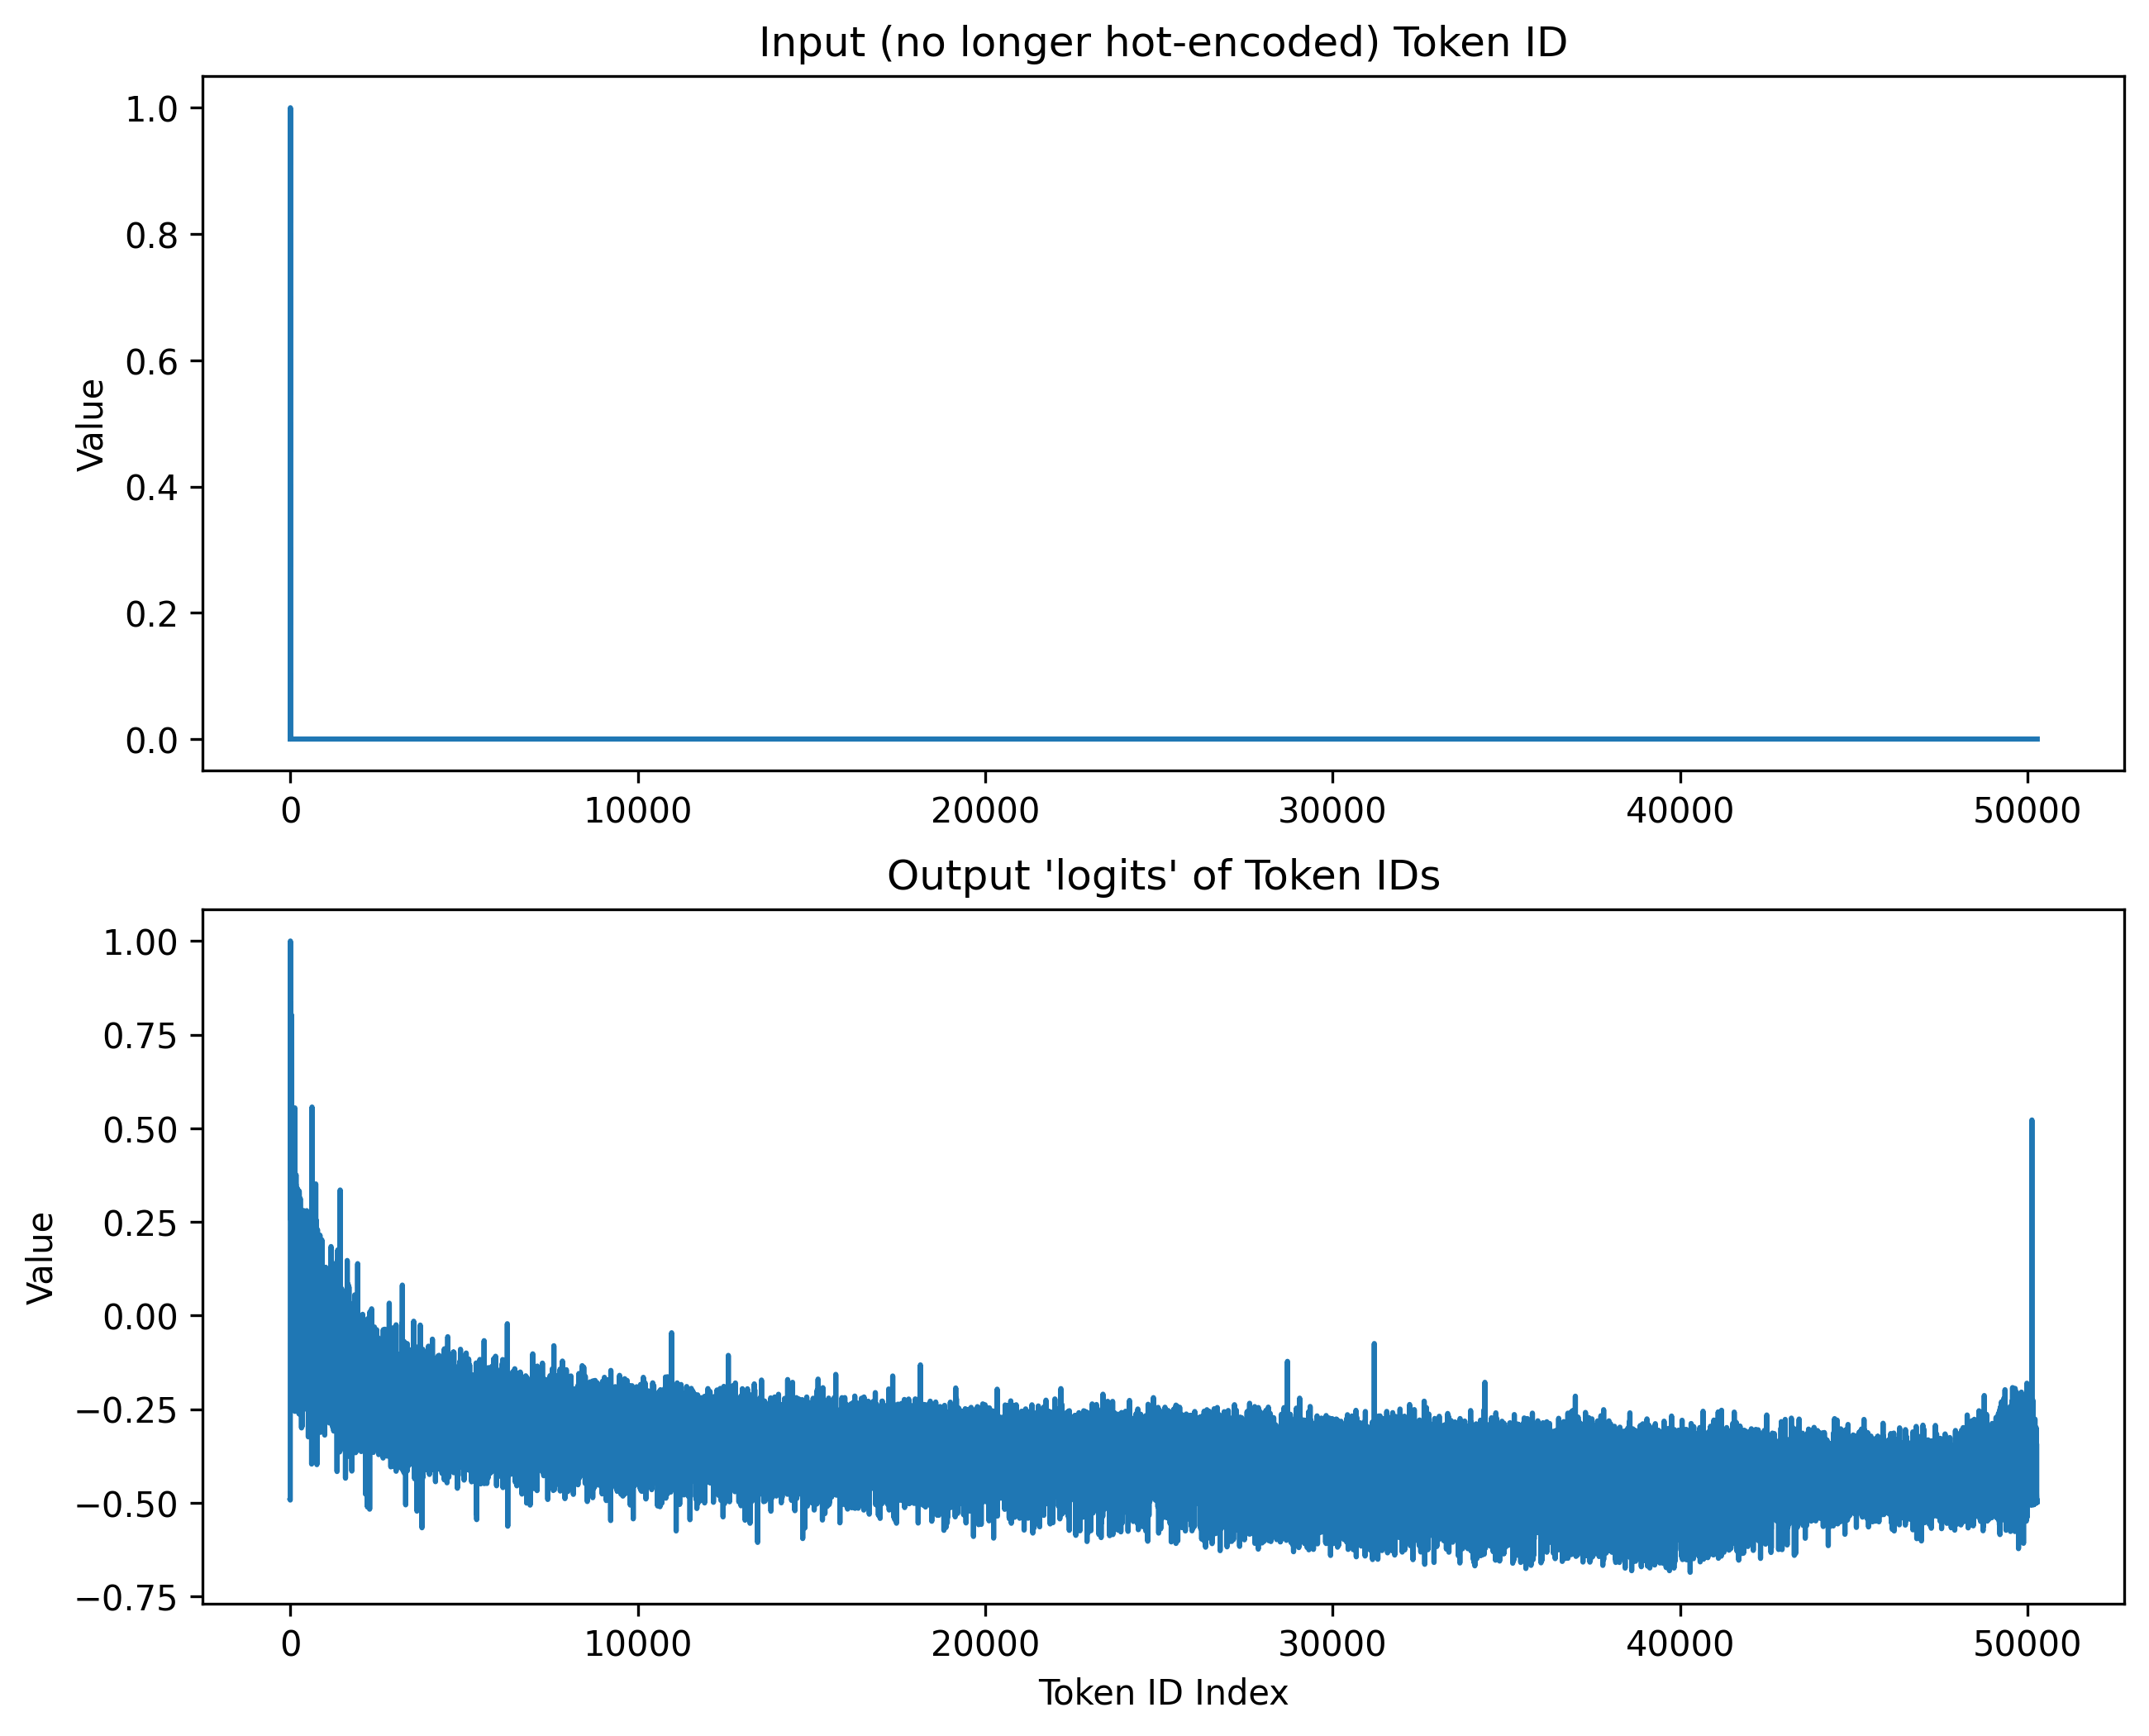

tensor([-0.4926, -0.4928,  0.1726, -0.4927,  0.4951,  1.0000,  0.5636,  0.6069,
         0.5547,  0.4955,  0.8338,  0.6522], device='cuda:0')
tensor(5, device='cuda:0')  the
' the' 5
' a' 10
' an' 41
' The' 20
' that' 14
' the' 5
' a' 10
' an' 41
' The' 20
' that' 14


In [48]:
norms = W_E.norm(dim=-1)
W_E_I = (W_E.T)*(1/(norms**2))
# W_E_I = W_E.T
print(W_E_I.T.norm(dim=-1))

TOKEN_ID = 5
TEMPERATURE = 1.0

blank_vector = torch.zeros(len(W_E)).to(W_E.device)
v = blank_vector
v[TOKEN_ID] = 1
print(opt.tokenizer.decode(TOKEN_ID))
print(v.size(), W_E.size(), W_E_I.size())
encoded = torch.matmul( v, W_E )
print(encoded.size())
decoded = torch.matmul( encoded*TEMPERATURE, W_E_I )

fix, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(v.cpu())
ax1.set_title("Input (no longer hot-encoded) Token ID")
ax1.set_ylabel("Value")

ax2.plot(decoded.cpu())
ax2.set_title("Output 'logits' of Token IDs")
ax2.set_xlabel("Token ID Index")
ax2.set_ylabel("Value")

plt.show()

print(decoded[:12])

decoded_id = torch.argmax(decoded)
print(decoded_id, opt.tokenizer.decode(decoded_id))
#plt.plot(torch.softmax(decoded*14, dim=-1).cpu())

topk = torch.topk( decoded, 5, dim=-1, largest=True, sorted=True )
for t in topk.indices:
    print(f"'{opt.tokenizer.decode(t)}'", t.cpu().item())
   
topk_first_5000 = torch.topk( decoded[:5000], 5, dim=-1, largest=True, sorted=True ) 
for t in topk_first_5000.indices:
    print(f"'{opt.tokenizer.decode(t)}'", t.cpu().item())

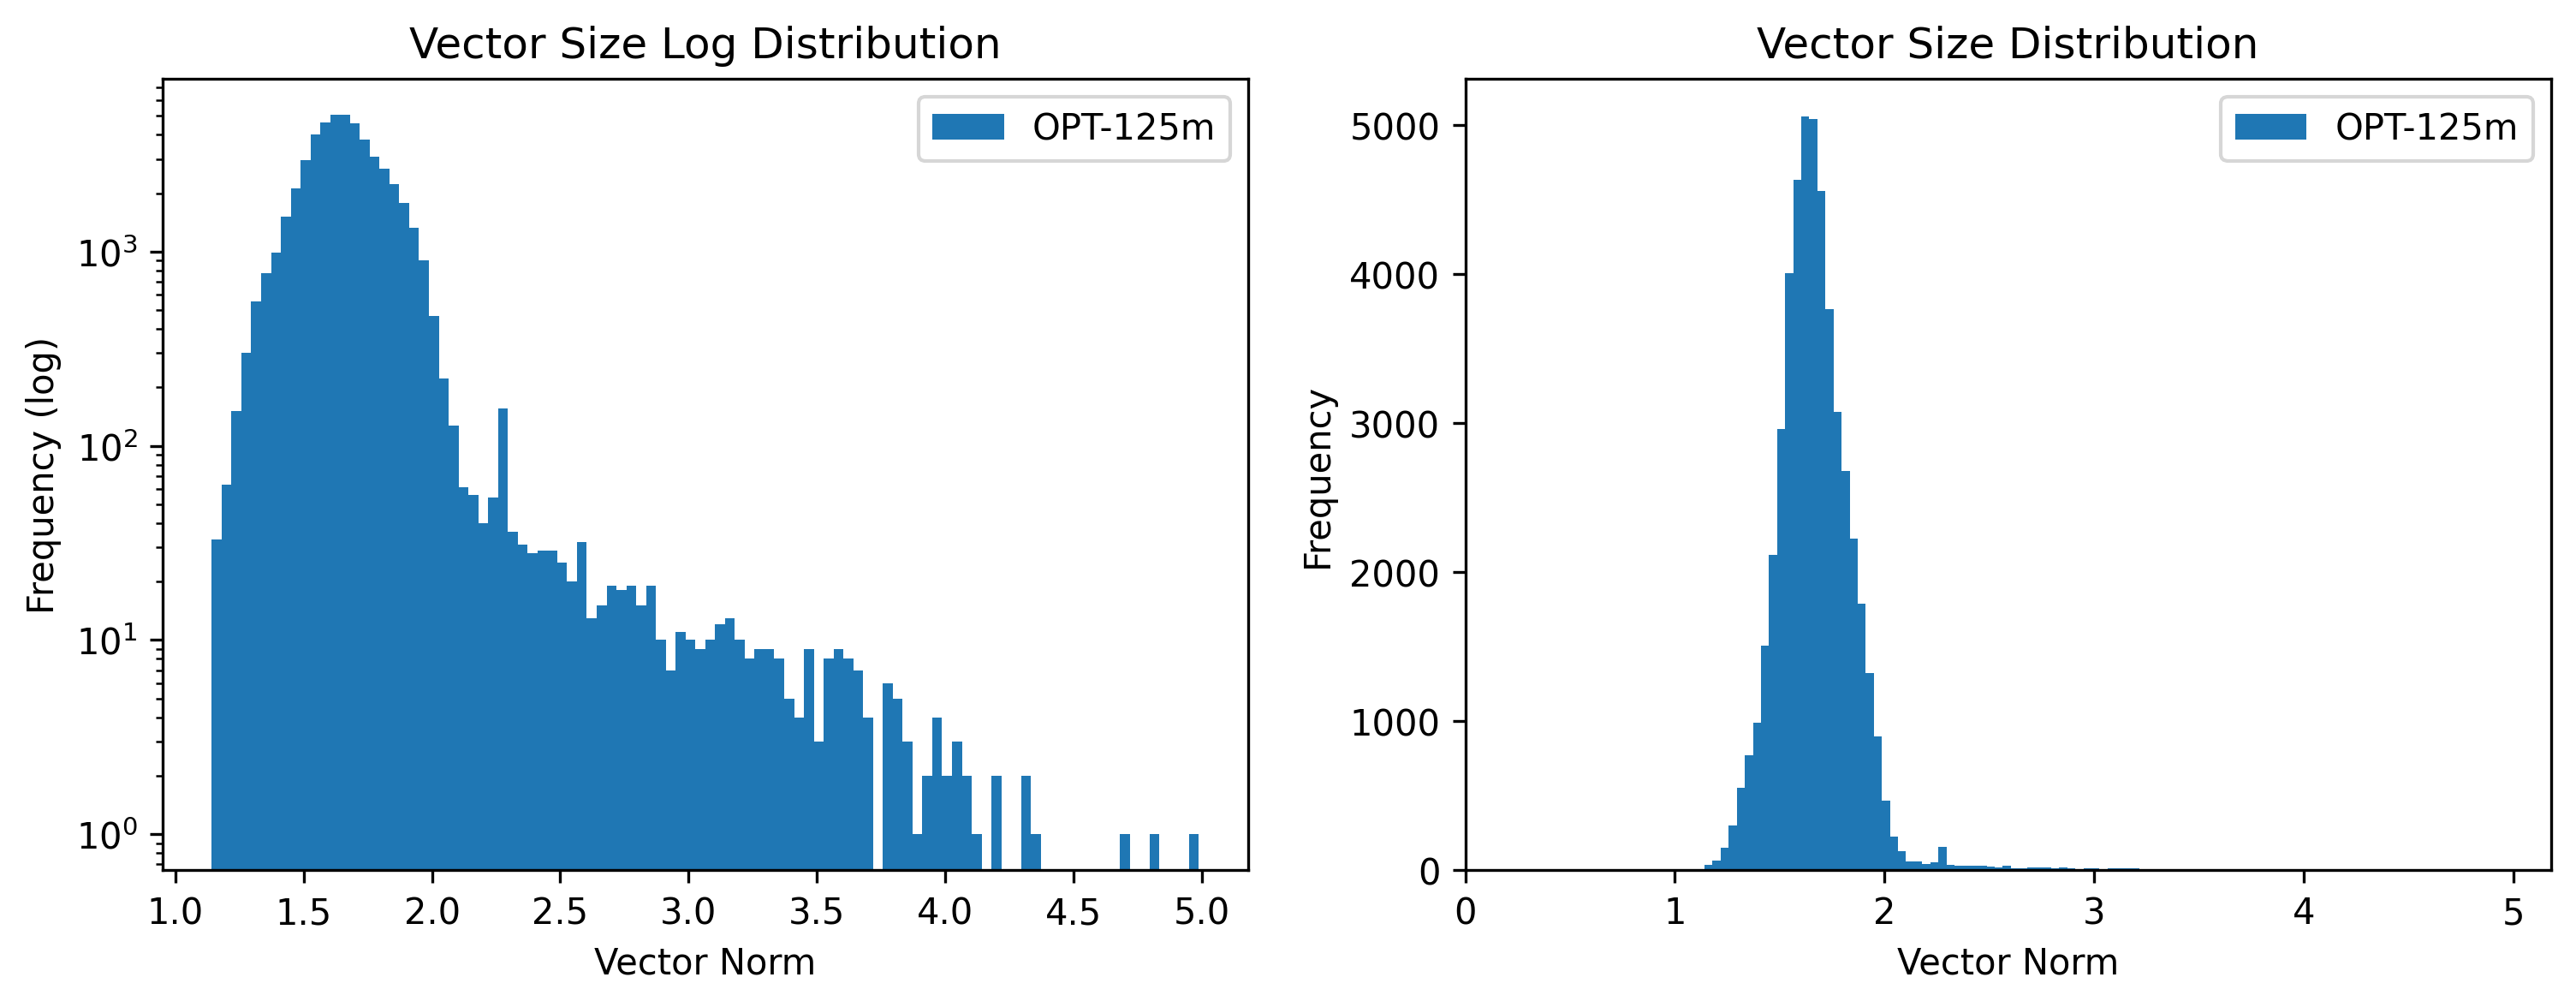

In [7]:
unembed = opt.predictor.get_output_embeddings().state_dict()["weight"]

norms = unembed.norm(dim=-1).cpu()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))        
 
ax1.hist( norms, bins=100, log=True, bottom=0, label="OPT-125m" )
ax1.set_xlabel("Vector Norm")
ax1.set_ylabel("Frequency (log)")
ax1.set_title("Vector Size Log Distribution")
ax1.legend()

ax2.hist( norms, bins=100, log=False, bottom=0, label="OPT-125m" )
ax2.set_title("Vector Size Distribution")
ax2.set_xlabel("Vector Norm")
ax2.set_ylabel("Frequency")

plt.xlim(0, None)
plt.legend()

plt.show()

In [41]:
for i in range(12):
    s = opt.tokenizer.decode(i)
    v = opt.get_inputs_embeds(input_ids=torch.tensor([i]).to(opt.device))
    print("%7s"%("'%s'"%s), '->', "%3s"%i,'->', v[0, :3].detach().cpu())

print()

  '<s>' ->   0 -> tensor([ 0.1150, -0.1438,  0.0555])
'<pad>' ->   1 -> tensor([ 0.1149, -0.1438,  0.0547])
 '</s>' ->   2 -> tensor([ 0.0010, -0.0922,  0.1025])
'<unk>' ->   3 -> tensor([ 0.1149, -0.1439,  0.0548])
    '.' ->   4 -> tensor([-0.0651, -0.0622, -0.0002])
 ' the' ->   5 -> tensor([-0.0340,  0.0068, -0.0844])
    ',' ->   6 -> tensor([ 0.0483, -0.0214, -0.0927])
  ' to' ->   7 -> tensor([-0.0439,  0.0201,  0.0189])
 ' and' ->   8 -> tensor([ 0.0523, -0.0208, -0.0254])
  ' of' ->   9 -> tensor([-0.0732,  0.0070, -0.0286])
   ' a' ->  10 -> tensor([-0.0194,  0.0302, -0.0838])
  ' in' ->  11 -> tensor([-0.0374,  0.0354, -0.0098])



In [44]:
for i in range(10):
    s = opt.tokenizer.decode(i)
    v = opt.get_inputs_embeds(input_ids=torch.tensor([i]).to(opt.device))
    print("%17s"%("'%s'"%s), '->', "%5s"%i,'->', v[0, :3].detach().cpu())

print("...")
vocab = opt.tokenizer.vocab_size 
for i in range(vocab-10, vocab):
    s = opt.tokenizer.decode(i)
    v = opt.get_inputs_embeds(input_ids=torch.tensor([i]).to(opt.device))
    print("%17s"%("'%s'"%s),'->', "%5s"%i,'->', v[0, :3].detach().cpu())

            '<s>' ->     0 -> tensor([ 0.1150, -0.1438,  0.0555])
          '<pad>' ->     1 -> tensor([ 0.1149, -0.1438,  0.0547])
           '</s>' ->     2 -> tensor([ 0.0010, -0.0922,  0.1025])
          '<unk>' ->     3 -> tensor([ 0.1149, -0.1439,  0.0548])
              '.' ->     4 -> tensor([-0.0651, -0.0622, -0.0002])
           ' the' ->     5 -> tensor([-0.0340,  0.0068, -0.0844])
              ',' ->     6 -> tensor([ 0.0483, -0.0214, -0.0927])
            ' to' ->     7 -> tensor([-0.0439,  0.0201,  0.0189])
           ' and' ->     8 -> tensor([ 0.0523, -0.0208, -0.0254])
            ' of' ->     9 -> tensor([-0.0732,  0.0070, -0.0286])
...
            '*=-' -> 50255 -> tensor([ 0.0643, -0.1254,  0.0907])
             'ÛÛ' -> 50256 -> tensor([ 0.1033, -0.1267,  0.1025])
    ' EntityItem' -> 50257 -> tensor([ 0.1267, -0.1744,  0.0618])
    'EngineDebug' -> 50258 -> tensor([ 0.1191, -0.1593,  0.0374])
' strutConnector' -> 50259 -> tensor([ 0.1150, -0.1438,  0.0555])
  '<|e

In [49]:
TOKEN_ID = 10000

for i in range(1):
    s = opt.tokenizer.decode(i)
    v = opt.get_inputs_embeds(input_ids=torch.tensor([i]).to(opt.device))
    print("%17s"%("'%s'"%s), '->', "%5s"%i,'->', v[0, :3].detach().cpu())
print("...")

for i in range(TOKEN_ID-2, TOKEN_ID+3):
    s = opt.tokenizer.decode(i)
    v = opt.get_inputs_embeds(input_ids=torch.tensor([i]).to(opt.device))
    print("%17s"%("'%s'"%s), '->', "%5s"%i,'->', v[0, :3].detach().cpu())

print("...")
vocab = opt.tokenizer.vocab_size 
for i in range(vocab-1, vocab):
    s = opt.tokenizer.decode(i)
    v = opt.get_inputs_embeds(input_ids=torch.tensor([i]).to(opt.device))
    print("%17s"%("'%s'"%s),'->', "%5s"%i,'->', v[0, :3].detach().cpu())

            '<s>' ->     0 -> tensor([ 0.1150, -0.1438,  0.0555])
...
        ' aiming' ->  9998 -> tensor([ 0.1100, -0.0419,  0.0132])
          'eland' ->  9999 -> tensor([ 0.0453, -0.1812, -0.0419])
          ' NEXT' -> 10000 -> tensor([ 0.0473, -0.1418, -0.0525])
          'tered' -> 10001 -> tensor([ 0.0113, -0.1265,  0.0714])
            'IVE' -> 10002 -> tensor([ 0.1133, -0.1754,  0.0957])
...
         '<mask>' -> 50264 -> tensor([ 0.1148, -0.1428,  0.0553])


In [43]:
print(opt.model.decoder.embed_tokens.state_dict()["weight"])
print(opt.model.decoder.embed_tokens.state_dict()["weight"].shape)

tensor([[ 0.1150, -0.1438,  0.0555,  ...,  0.2146,  0.0833,  0.0669],
        [ 0.1149, -0.1438,  0.0547,  ...,  0.2145,  0.0833,  0.0669],
        [ 0.0010, -0.0922,  0.1025,  ..., -0.0402,  0.0060, -0.1078],
        ...,
        [ 0.1152, -0.1437,  0.0547,  ...,  0.2145,  0.0833,  0.0671],
        [ 0.1151, -0.1455,  0.0546,  ...,  0.2156,  0.0837,  0.0673],
        [ 0.1156, -0.1437,  0.0577,  ...,  0.2139,  0.0833,  0.0650]],
       device='cuda:0')
torch.Size([50272, 768])


(' John and Mary went to the bar. John bought a drink for', ' Mary')
in: 13 out: 2708
tensor(-0.3518, device='cuda:0')
tensor(3.2596e-09, device='cuda:0')
torch.Size([25, 768])
final size: 8.176281622975319
-1.490130104146542 8.039347552273691


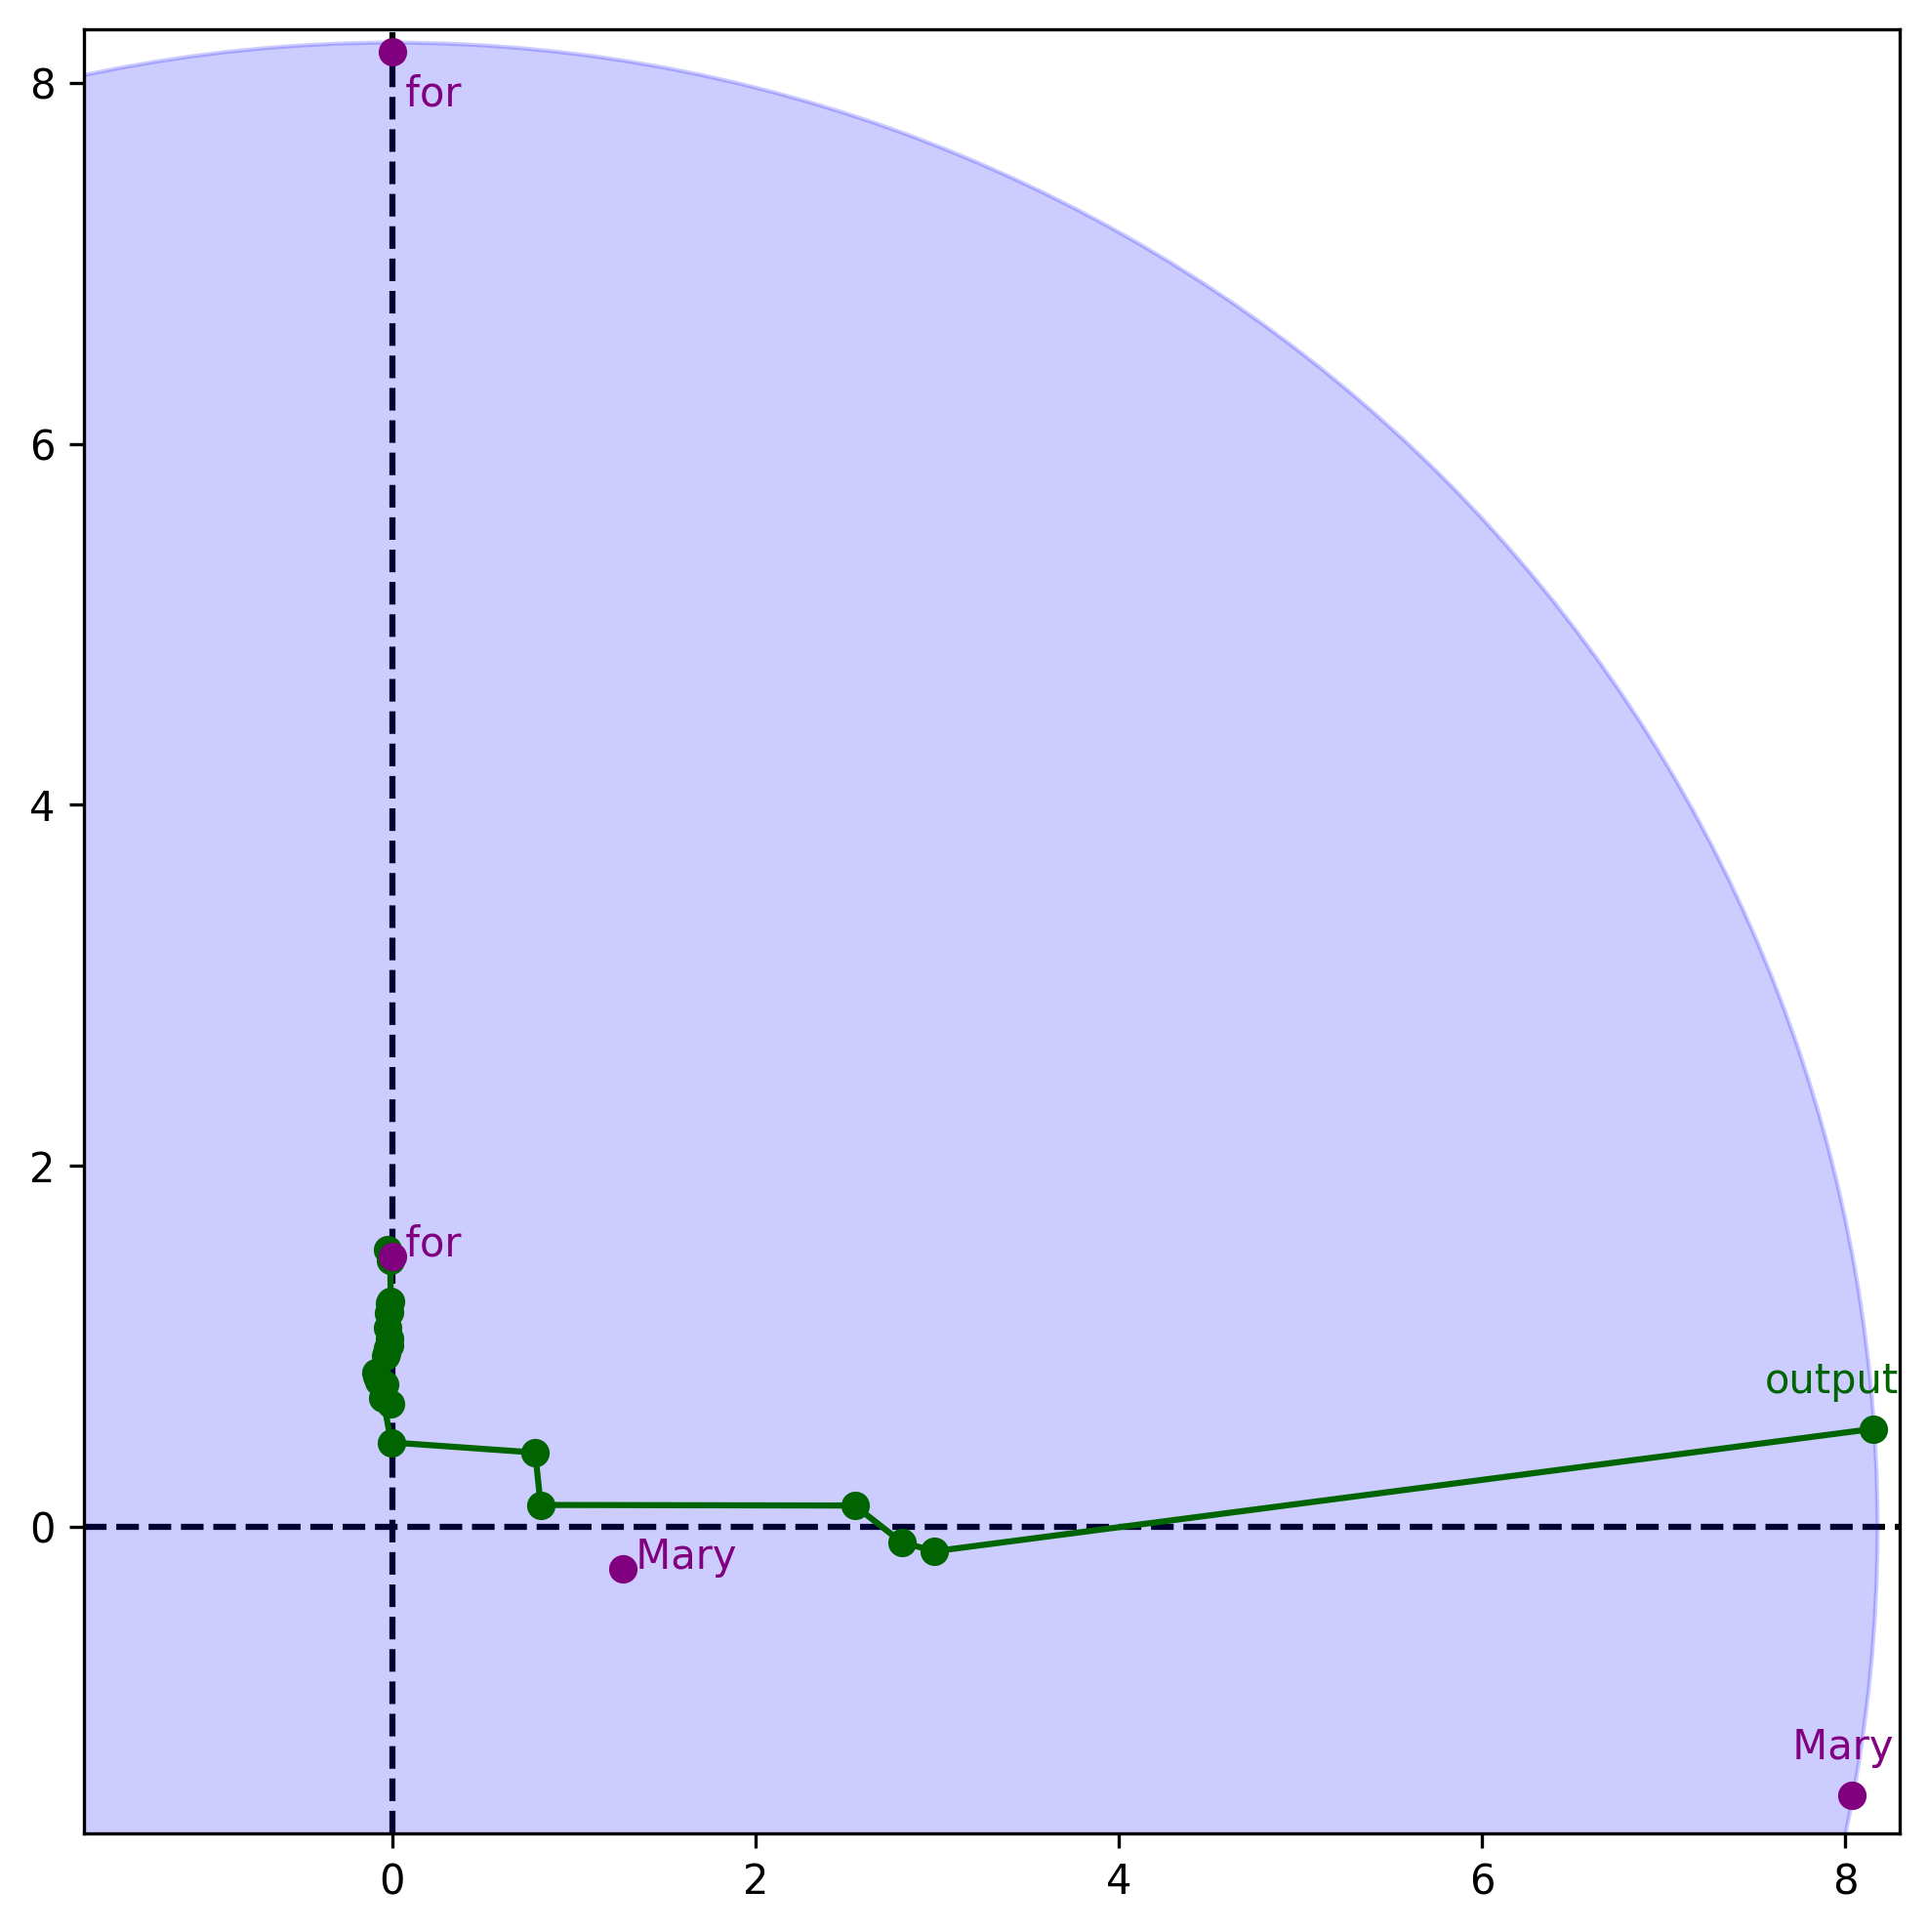

In [127]:
text = " John and Mary went to the bar. John bought a drink for"

print( opt.predict(text, num=1) ) 
in_str = " for"
out_str = " Mary"
in_token  = opt.tokenizer.encode(in_str)[-1:][0]
out_token = opt.tokenizer.encode(out_str)[-1:][0]
print('in:', in_token, 'out:', out_token)

in_vec = opt.get_inputs_embeds(input_ids=torch.tensor([in_token]).to(opt.device))[0].detach()
out_vec = opt.get_inputs_embeds(input_ids=torch.tensor([out_token]).to(opt.device))[0].detach()

# get basis of two orthogonal vectors
vec_x = in_vec / in_vec.norm()
vec_y = out_vec - vec_x * torch.dot(vec_x, out_vec)
vec_y = vec_y / vec_y.norm()

print(torch.dot(in_vec, out_vec))
print(torch.dot(vec_x, vec_y))

# save coords
in_vec_x = torch.dot(in_vec, vec_x).cpu().item()
in_vec_y = torch.dot(in_vec, vec_y).cpu().item()
out_vec_x = torch.dot(out_vec, vec_x).cpu().item()
out_vec_y = torch.dot(out_vec, vec_y).cpu().item()

residual = opt.get_residual_stream(text).transpose(0, 1)[-1]
print(residual.shape)

xs, ys = [], []
for vec in residual:
   xs.append(torch.dot(vec, vec_x).cpu().item())
   ys.append(torch.dot(vec, vec_y).cpu().item())
   
final_size = ( xs[-1]**2 + ys[-1]**2 )**(0.5)
print("final size:", final_size)
marker_size = 9 * 10 * final_size
   
plt.figure(figsize=(8, 8))
MIN, MAX = -1.7, 8.3
plt.xlim(MIN, MAX)
plt.ylim(MIN, MAX)
plt.hlines(0, MIN, MAX, linestyles='dashed', colors='black')
plt.vlines(0, MIN, MAX, linestyles='dashed', colors='black')
plt.plot(0,0, marker='o', color='blue', markersize=730, alpha=0.2)

plt.plot(ys, xs, color='darkgreen', marker='o', linestyle='solid')
plt.annotate("output", (ys[-1]-0.6, xs[-1]+0.2), color='darkgreen')

# plot token points
plt.plot(in_vec_y, in_vec_x, marker='o', color='purple')
plt.plot(out_vec_y, out_vec_x, marker='o', color='purple')
plt.annotate(in_str, (in_vec_y, in_vec_x), color='purple')
plt.annotate(out_str, (out_vec_y, out_vec_x), color='purple')

# scaled token points
in_vec_x_scaled = in_vec_x * final_size / in_vec.norm().cpu().item()
in_vec_y_scaled = in_vec_y * final_size / in_vec.norm().cpu().item()
out_vec_x_scaled = out_vec_x * final_size / out_vec.norm().cpu().item()
out_vec_y_scaled = out_vec_y * final_size / out_vec.norm().cpu().item()
plt.plot(in_vec_y_scaled, in_vec_x_scaled, marker='o', color='purple')
plt.plot(out_vec_y_scaled, out_vec_x_scaled, marker='o', color='purple')
plt.annotate(in_str, (in_vec_y_scaled, in_vec_x_scaled-0.3), color='purple')
plt.annotate(out_str, (out_vec_y_scaled-0.4, out_vec_x_scaled+0.2), color='purple')

print(out_vec_x_scaled, out_vec_y_scaled)
